In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [4]:
def f(x):
    return 3 * x * x - 4 * x + 5

In [5]:
f(4.0)

37.0

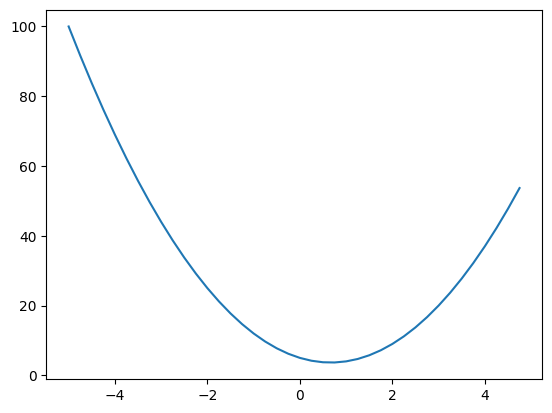

In [6]:
x_values = np.arange(-5, 5, 0.25)

y_values = f(x_values)

plt.plot(x_values, y_values)

# Remember Derivatives

You derive the derivative by basically doing the limit as h goes to zero of (f(a + h) - f(a)) / h

In [7]:
h = 0.001
x = 2.0

print(f"f(x) is {f(x)}")
print(f"f(x + h) is {f(x + h)}")

f(x) is 9.0
f(x + h) is 9.008003


In [8]:
# derivative is just finding the "slope" of this extremely tiny region
# DERIVATIVE IS JUST THE "SLOPE" OF THE LINE FORMED BY f(x) and f(x + 0.00001)!!!!

print(f"derivative (f(x + h) - f(x)) / h is {(f(x + h) - f(x)) / h}")

derivative (f(x + h) - f(x)) / h is 8.003000000000426


# More complexity

Function of multiple inputs

In [9]:
a = 2.0
b = -3.0
c = 10.0

d = a * b + c
print(d)

4.0


In [10]:
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c


print("d1", d1)
print("d2", d2)   # increasing a decreases! Partial derivative with respect to a is just the value of b! That's the "slope"

print("slope", (d2 - d1) / h)

d1 4.0
d2 4.002
slope 1.9999999999997797


# start of smolgrad library

In [11]:
class Value:
    def __init__(self, data):
        self.data = data
    
    def __add__(self, other):
        added_res = self.data + other.data
        return added_res
    
    def __mul__(self, other):
        added_res = self.data * other.data
        return added_res

    def __repr__(self):
        return f"VALUE(DATA = {self.data})" # PRINTS THIS OUT
    
a = Value(2.0)
b = Value(-3.0)

print(a + b)   # same as a.__add__(b)
print(a * b)
print(a)

-1.0
-6.0
VALUE(DATA = 2.0)


In [12]:
class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self._prev = set(_children)   # need to know values that PRODUCED this value
        self._op = _op   # also the OP that produced this value
        
        self.label = label
        
    
    def __add__(self, other):
        added_res = Value(self.data + other.data, (self, other), "+")
        
        return added_res
    
    def __mul__(self, other):
        added_res = Value(self.data*+ other.data, (self, other), "*")
        return added_res

    def __repr__(self):
        return f"VALUE(DATA = {self.data})" # PRINTS THIS OUT
    
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

e = a * b
e.label = 'e'

d = e + c
d.label = 'd'

f = Value(-2.0, label="f")


L = d * f
L.label = "L"


print(L._prev)  # SET of the values that produced this value

{VALUE(DATA = -2.0), VALUE(DATA = 4.0)}


In [13]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
#     dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

ModuleNotFoundError: No module named 'graphviz'

In [14]:
draw_dot(L)

NameError: name 'draw_dot' is not defined

# Great! Let's find the derivative via chain rule!

Need to, for each node, keep track of the DERIVATIVE with respect to JUST THE INPUT VALUES

In [15]:
class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self._prev = set(_children)   # need to know values that PRODUCED this value
        self._op = _op   # also the OP that produced this value
        self.label = label
        
        
        self.grad = 0.0  # THE GRADIENT VALUE FOR THIS SPECIFIC NODE: THIS SHOULD BE EQUAL TO  (dL / dthis_node)
        
    
    def __add__(self, other):
        added_res = Value(self.data + other.data, (self, other), "+")
        
        return added_res
    
    def __mul__(self, other):
        added_res = Value(self.data*+ other.data, (self, other), "*")
        return added_res

    def __repr__(self):
        return f"VALUE(DATA = {self.data})" # PRINTS THIS OUT
    
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

e = a * b
e.label = 'e'

d = e + c
d.label = 'd'

f = Value(-2.0, label="f")


L = d * f
L.label = "L"


print(L._prev)  # SET of the values that produced this value

{VALUE(DATA = 4.0), VALUE(DATA = -2.0)}


In [33]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
#     dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

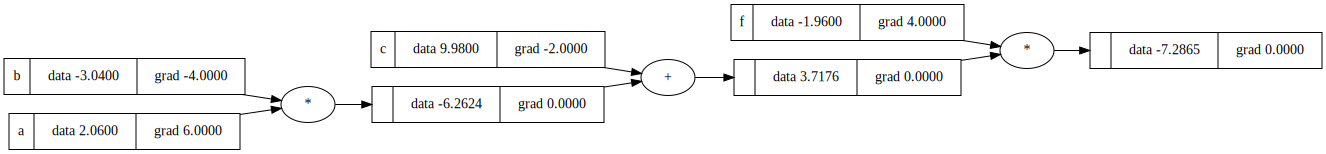

In [34]:
draw_dot(L)

In [35]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data

# This just follows from normal gradient rules, i.e. d(d * f) / dd = f, d(d * f) / df = d, etc.

In [36]:
# Want to find dL / dc
# Already know dL / dd, just need to know dd/dc

# dd/dc is easy!   d = c + e, so dd/dc = 1.0

c.grad = 0.0     # WANT dL  /  dc

dL_over_dd = d.grad
dd_over_dc = 1.0

c.grad = dL_over_dd * dd_over_dc
c.grad = d.grad * 1.0     # + node makes the ancestor nodes' "grad" equal to the output node's "grad", since derivative is just one

e.grad = d.grad * 1.0

print(c.grad)



-6.0


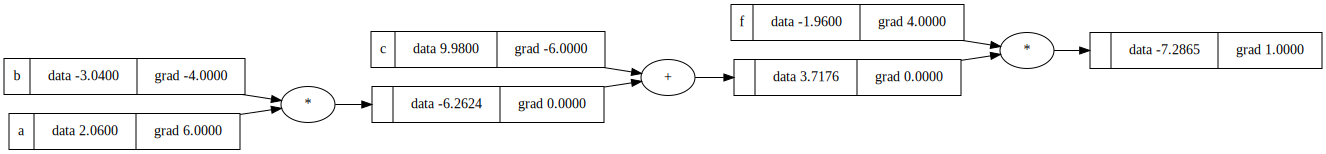

In [37]:
draw_dot(L)    # NOTICE HOW C's GRAD CHANGED TO BE THE SAME AS D's GRAD!!!

In [38]:
# Keep propogating backwards!
# want dL / da = dL/de * de/da

a.grad = e.grad * b.data   # de / da is just whatever b's value is
b.grad = e.grad * a.data   # de / db is just whatever a's value is

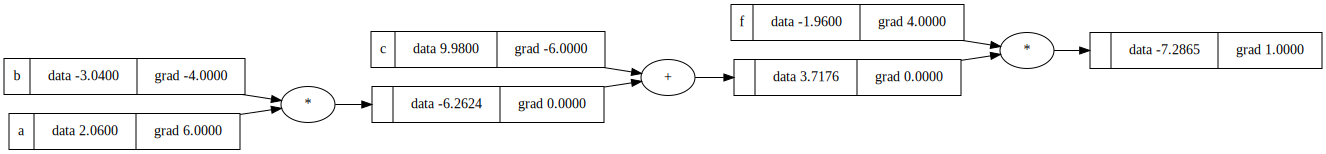

In [39]:
draw_dot(L)

You can see: literally just just iterate through every single node one by one in a single layer. Get a handle on the FORWARD gradient, and multiply THAT by the NODE's LOCAL gradient value (with respect to some input), and BAM: you have that "layer's" nodes' appropriate "grad" values!


Remember that "grad" is just derivative of L (my final output) with respect to that particular node.

In [40]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

TypeError: unsupported operand type(s) for +: 'float' and 'Value'

In [41]:
class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self._prev = set(_children)   # need to know values that PRODUCED this value
        self._op = _op   # also the OP that produced this value
        self.label = label
        
        
        self.grad = 0.0  # THE GRADIENT VALUE FOR THIS SPECIFIC NODE: THIS SHOULD BE EQUAL TO  (dL / dthis_node)
        
    
    def __add__(self, other):
        added_res = Value(self.data + other.data, (self, other), "+")
        
        return added_res
    
    def __mul__(self, other):
        added_res = Value(self.data*+ other.data, (self, other), "*")
        return added_res

    def __repr__(self):
        return f"VALUE(DATA = {self.data})" # PRINTS THIS OUT
    
    def tanh(self):
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)  # computes tanh of this node's value
        output_node = Value(t, (self, ), 'tanh')
        return output_node
    


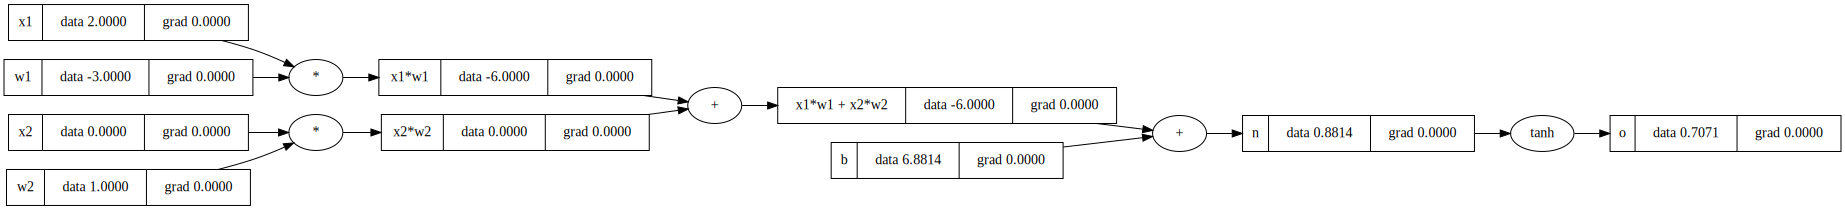

In [42]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


draw_dot(o)
## Want to find derivative of o with respect to all my inputs w1, w2, etc at the first layer of the graph

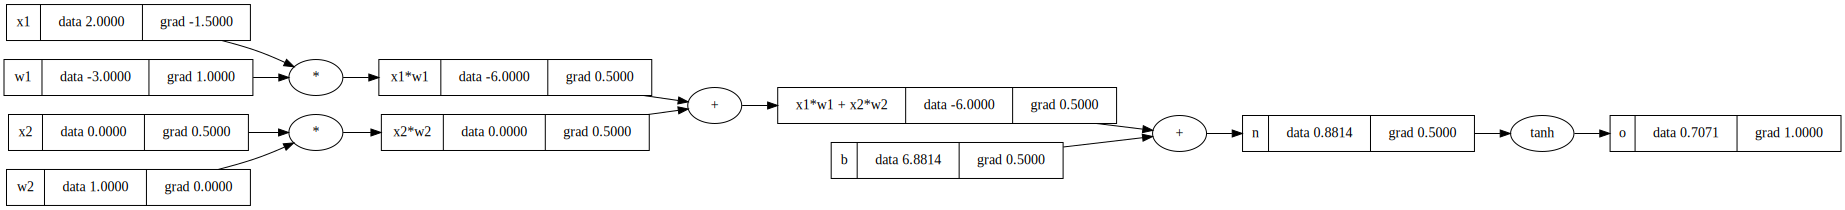

In [43]:
o.grad = 1.0

# do/dn = 1 - o**2
local_gradient = 1- o.data**2
n.grad = o.grad * local_gradient


# b and x1*w1+x2*w2 are just a plus node so forward gradient just flows through and gets copied in the children
b.grad = n.grad * 1.0
x1w1x2w2.grad = n.grad * 1.0

# continuing on, x1w1 and x2w2 are another plus node, so you just copy (man, plus nodes are great, aren't they?)
x1w1.grad = x1w1x2w2.grad * 1.0
x2w2.grad = x1w1x2w2.grad * 1.0


# now for the raw inputs... nothing we can't do! Just a multiplication node, i.e. take the VALUE of the other input, and multiply that by the forward gradient!
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)

# NOTICE HOW w2 HAS GRAD 0: THIS BECAUSE X2 HAS VALUE 0, SO WIGGLING w2 DOES NOTHING w.r.t FINAL OUTPUT o 

# It's annoying to constantly have to manually write out the gradients, so let's handle this stuff automagically!

First step is to keep track of a _backward property

In [44]:
class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self._prev = set(_children)   # need to know values that PRODUCED this value
        self._op = _op   # also the OP that produced this value
        self.label = label
        
        self._backward = lambda: None
        
        
        self.grad = 0.0  # THE GRADIENT VALUE FOR THIS SPECIFIC NODE: THIS SHOULD BE EQUAL TO  (dL / dthis_node)
        
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        
        def _backward():   # let's say we're doing c = a + b
            self.grad = out.grad * 1.0    # find THIS node's grad i.e. dL/da = dL/dc * dc/da
            other.grad = out.grad * 1.0   # find the OTHER NODE we're adding's grad i.e. dL/db = dL/dc * dc/db
            
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
            
        out._backward = _backward
            
        return out
    
    

    def __repr__(self):
        return f"VALUE(DATA = {self.data})" # PRINTS THIS OUT
    
    def tanh(self):
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)  # computes tanh of this node's value
        
        output_node = Value(t, (self, ), 'tanh')   # remember, technically someone's already called ._backward() on this node, so this grad should have a valid value in it!!!
        
        def _backward():
            self.grad = output_node.grad * (1- output_node.data**2)
        
        output_node._backward = _backward
        
        return output_node
    


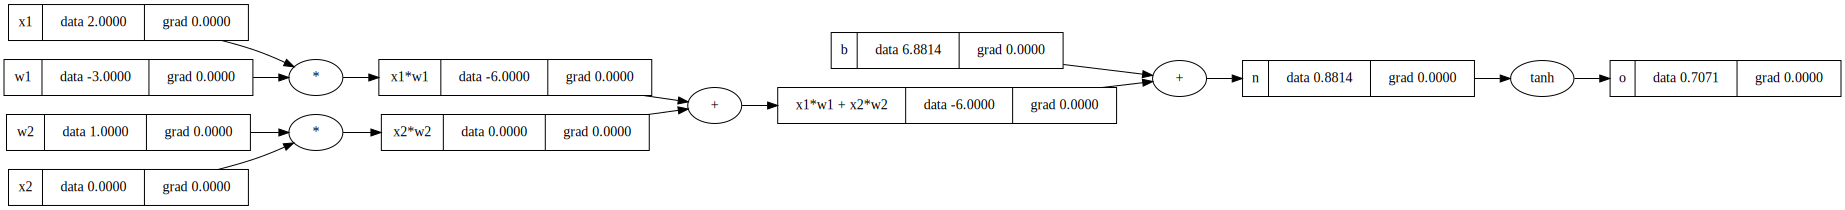

In [45]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


draw_dot(o)
## Want to find derivative of o with respect to all my inputs w1, w2, etc at the first layer of the graph

None


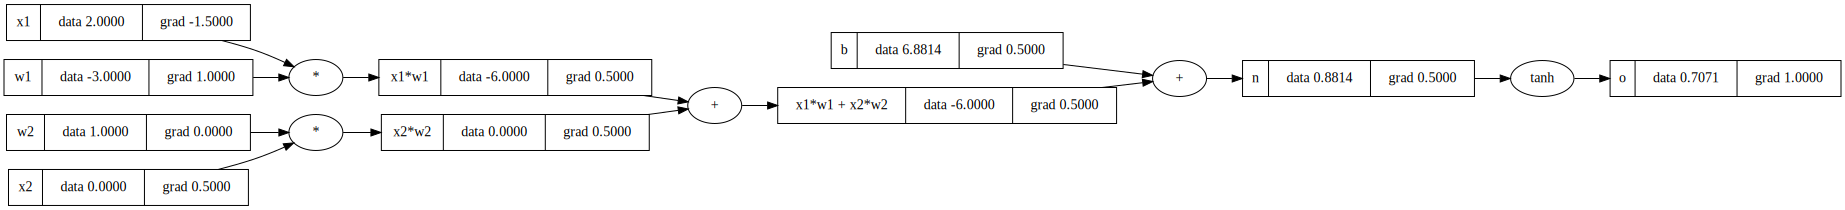

In [46]:
# now let's do backprop!

o.grad = 1.0

# ORDERING MATTERS A LOT! BACKWARD CALLS NEED TO HAPPEN IN TOPOLOFICALLY SORTED ALGO!

o._backward()  # finds and stores grad of n
n._backward()  # finds and stores grad of x1w1x2w2 and b

b._backward()  # does nothing: b's _backward function never gets set to anything!
print(b._backward())  # prints None

x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()


draw_dot(o)

In [47]:
# ... now it's annoying to manually topological sort all of the nodes, and then manually call _backward() on all of them
# so we'll just add some code that automatically topsorts the nodes, and then calls _backward() on all of them in the right order
# so you don't have to manually....

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
    
build_topo(o)

for node in reversed(topo):
    print(node.data)
    

0.7071067811865476
0.8813735870195432
-6.0
0.0
0.0
1.0
-6.0
-3.0
2.0
6.881373587019543


In [48]:
# Great, now let's add a dedicated backward() function

class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self._prev = set(_children)   # need to know values that PRODUCED this value
        self._op = _op   # also the OP that produced this value
        self.label = label
        
        self.grad = 0
        
        self._backward = lambda: None
        
        
        self.grad = 0.0  # THE GRADIENT VALUE FOR THIS SPECIFIC NODE: THIS SHOULD BE EQUAL TO  (dL / dthis_node)
        
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        
        def _backward():   # let's say we're doing c = a + b
            
            # assuming self is not other....
            self.grad += out.grad * 1.0    # find THIS node's grad i.e. dL/da = dL/dc * dc/da
            other.grad += out.grad * 1.0   # find the OTHER NODE we're adding's grad i.e. dL/db = dL/dc * dc/db
            
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            
        out._backward = _backward
            
        return out
    
    def __repr__(self):
        return f"VALUE(DATA = {self.data})" # PRINTS THIS OUT
    
    def tanh(self):
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)  # computes tanh of this node's value
        
        output_node = Value(t, (self, ), 'tanh')   # remember, technically someone's already called ._backward() on this node, so this grad should have a valid value in it!!!
        
        def _backward():
            self.grad = output_node.grad * (1- output_node.data**2)
        
        output_node._backward = _backward
        
        return output_node
    
    def backward(self): 
        # get topsorted list STARTING FROM THIS NODE
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)

        build_topo(self)
        
        self.grad = 1.0   # NEED TO SET THIS NODE'S GRAD TO BE 1.0!!!
        for node in reversed(topo):
            node._backward()



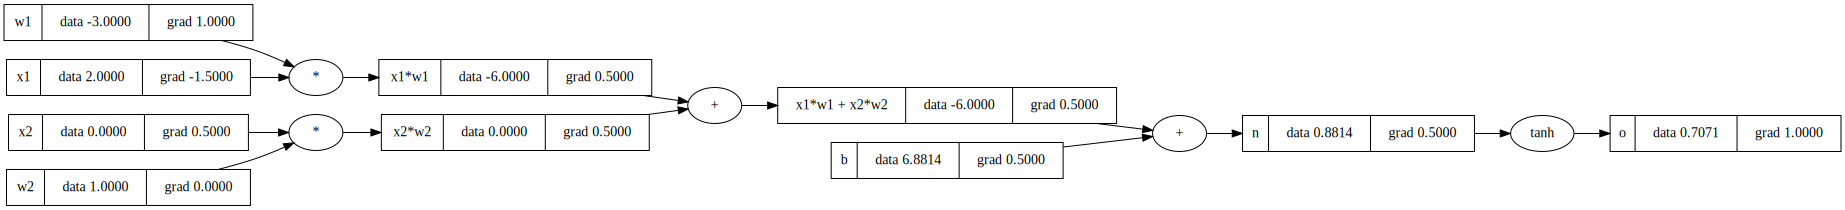

In [49]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


# calling this fills in all the gradient values for ALL nodes!
o.backward()



draw_dot(o)

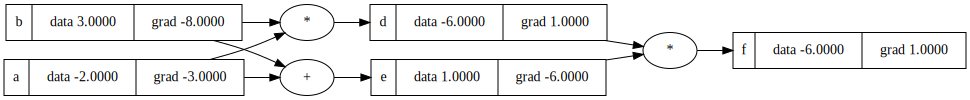

In [50]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b
d.label = 'd'

e = a + b
e.label = 'e'

# Here, E and D both take a and b as inputs.
# Thus, the "grad" value for a and b is the ADDITION of both sets of grad values! We add them all up!

# you ACCUMULATE all fo the relevant gradient terms. W.r.t a, you add the gradient term from d WITH the gradient term from e
# a is (1.0 * -6) from the e term, added to (1.0 * 3) from the d term, and thus it's -3.0!

f = d * e
f.label = 'f'

f.backward()

draw_dot(f)

# Great! Now let's practice breaking down tanh into constituent parts

In [51]:
# Great, now let's add a dedicated backward() function

class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self._prev = set(_children)   # need to know values that PRODUCED this value
        self._op = _op   # also the OP that produced this value
        self.label = label
        
        self.grad = 0
        
        self._backward = lambda: None
        
        
        self.grad = 0.0  # THE GRADIENT VALUE FOR THIS SPECIFIC NODE: THIS SHOULD BE EQUAL TO  (dL / dthis_node)
        
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        
        def _backward():   # let's say we're doing c = a + b
            
            # assuming self is not other....
            self.grad += out.grad * 1.0    # find THIS node's grad i.e. dL/da = dL/dc * dc/da
            other.grad += out.grad * 1.0   # find the OTHER NODE we're adding's grad i.e. dL/db = dL/dc * dc/db
            
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)   # this just makes sure we're adding a value
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            
        out._backward = _backward
        return out

    def __rmul__(self, other):   # avoid a multiplication op error
        return self * other
            
    
    def __repr__(self):
        return f"VALUE(DATA = {self.data})" # PRINTS THIS OUT
    
    def tanh(self):
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)  # computes tanh of this node's value
        
        output_node = Value(t, (self, ), 'tanh')   # remember, technically someone's already called ._backward() on this node, so this grad should have a valid value in it!!!
        
        def _backward():
            self.grad = output_node.grad * (1- output_node.data**2)
        
        output_node._backward = _backward
        
        return output_node
    
    
    # more functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.grad * math.exp(x)
        out._backward = _backward
        
        return out
    
    
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    
    def __pow__(self, other):
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += out.grad * other * (self.data ** (other - 1))
        out._backward = _backward
        
        return out
    
    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    
    def backward(self): 
        # get topsorted list STARTING FROM THIS NODE
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)

        build_topo(self)
        
        self.grad = 1.0   # NEED TO SET THIS NODE'S GRAD TO BE 1.0!!!
        for node in reversed(topo):
            node._backward()



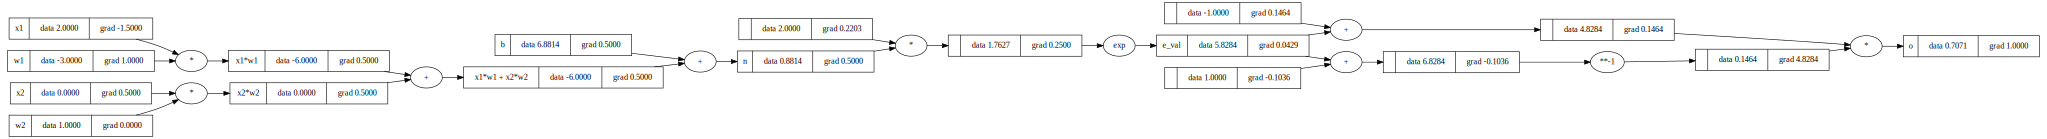

In [52]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# manually writing out tanh
e_val = (2 * n).exp()
e_val.label = "e_val"
o = (e_val - 1) / (e_val + 1)


# calling this fills in all the gradient values for ALL nodes!
o.label = 'o'
o.backward()

draw_dot(o)

In [53]:
# CHECK WITH PYTORCH IMPLEMENTATION
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True    # requires_grad means store the grad (i.e. do / dx1) for this node
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())   # item auto-extracts the singular item out of the tensor, for
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [56]:
x1.grad  # a tensor object

tensor([-1.5000], dtype=torch.float64)

In [75]:
# IMPLEMENT OWN NEURON THING WITH MICROGRAD


class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()   # THEN APPLY TANH
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [127]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])   # 3 inputs, 3 layers of 4 neurons, 4 neurons, then 1 output neuron
n(x)

VALUE(DATA = -0.4366926460656935)

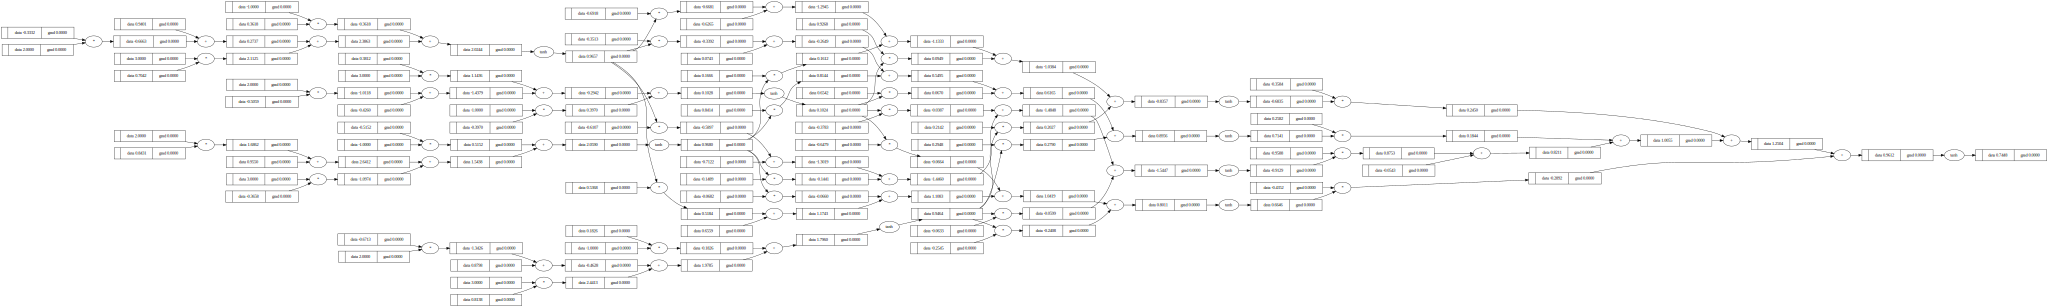

In [80]:
draw_dot(n(x))

In [125]:
# EXAMPLE TRAINING DATA

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]

ypred

[VALUE(DATA = -0.9999990363318864),
 VALUE(DATA = -0.9999988603655919),
 VALUE(DATA = -0.999999126295193),
 VALUE(DATA = -0.9999992107606357)]

In [95]:
loss = sum((yout - yguess)**2 for yguess, yout in zip(ys, ypred))
loss

VALUE(DATA = 3.7817712771481586)

In [94]:
loss.backward()

In [88]:
n.layers[0].neurons[0].w[0].data  # ONE SPECIFIC WEIGHT VALUE

-0.33317060413159116

In [85]:
 n.layers[0].neurons[0].w[0].grad  # ONE SPECIFIC GRAD IN ONE SPECIFIC LAYER (direction to nudge that data value to get less loss)

2.1953192597870457

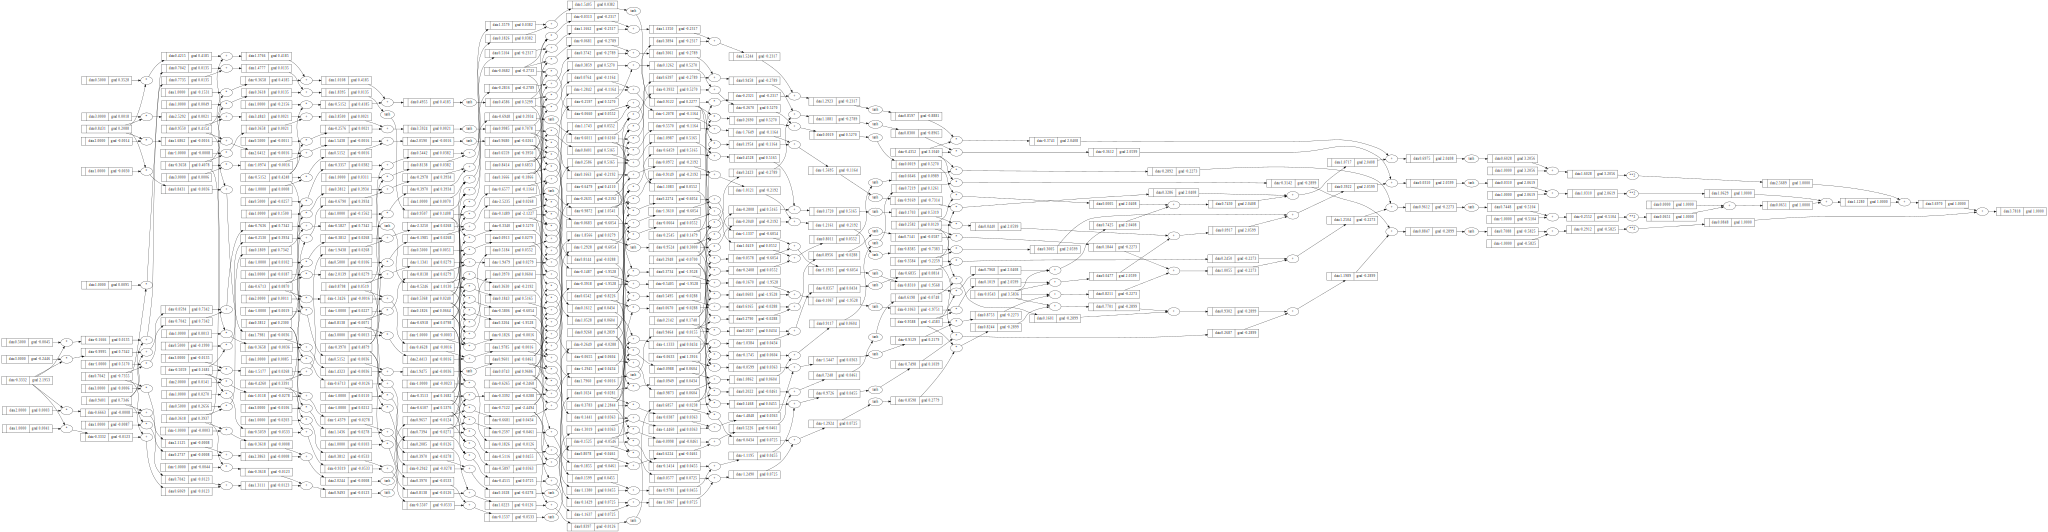

In [86]:
draw_dot(loss)   # HAS 4 FORWARD PASSES + LOSS ON TOP

In [ ]:
# note how the grad values for the input values aren't useful (we can't change those)

In [87]:
# Now let's nudge the params a small amount!
n.parameters()  # these are our param values:

[VALUE(DATA = -0.33317060413159116),
 VALUE(DATA = 0.7041829840922931),
 VALUE(DATA = 0.3618256540329994),
 VALUE(DATA = 0.9400641150631324),
 VALUE(DATA = 0.8430797449975764),
 VALUE(DATA = -0.3657904705791415),
 VALUE(DATA = -0.515235491837758),
 VALUE(DATA = 0.9550193420163968),
 VALUE(DATA = -0.5059008886562284),
 VALUE(DATA = 0.3812130537579017),
 VALUE(DATA = -0.3970047411760298),
 VALUE(DATA = -0.4260486796665759),
 VALUE(DATA = -0.6713131492697868),
 VALUE(DATA = 0.8137819666101704),
 VALUE(DATA = 0.18256230640689686),
 VALUE(DATA = 0.8798241953794197),
 VALUE(DATA = -0.6106583650304613),
 VALUE(DATA = -0.14888253721880607),
 VALUE(DATA = -0.3782651609492076),
 VALUE(DATA = -0.0633286858523443),
 VALUE(DATA = -0.7121882019354306),
 VALUE(DATA = -0.35126491973317076),
 VALUE(DATA = 0.8413880681336074),
 VALUE(DATA = 0.6542166296604295),
 VALUE(DATA = 0.29484668480676257),
 VALUE(DATA = 0.07428295886795344),
 VALUE(DATA = -0.6918151106266377),
 VALUE(DATA = 0.1665680427996199),
 

# Now, let's put it all together!

Neural net is just:
1. Forward pass
2. Backward pass
3. Update weights

Just running these 3 blocks, you can see the loss is decreasing!

In [143]:
# FORWARD PASS

ypred = [n(x) for x in xs]
loss = sum((yout - yguess)**2 for yguess, yout in zip(ys, ypred))
loss

VALUE(DATA = 3.322346291385557)

In [144]:
loss.backward()

In [145]:
for p in n.parameters():
    p.data += -0.01 * p.grad    # FOR ALL OF OUR PARAMETERS (listed above), STEP SIZE W.R.T THE GRADIENT!!!

In [146]:
ypred

[VALUE(DATA = 0.08708032346645692),
 VALUE(DATA = 0.011933384139688285),
 VALUE(DATA = -0.10903253688895287),
 VALUE(DATA = 0.180798094896923)]

# Let's do it in epochs:

In [150]:
for i in range(10):
    # forward:
    ypred = [n(x) for x in xs]
    loss = sum((yout - yguess)**2 for yguess, yout in zip(ys, ypred))
    
    # backward pass
    # NOW NEED TO RESET ALL OF THE GRAD VALUES TO 0!!! DOING ON NEW WEIGHTS, WANT TO RESTART
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad
        
    
    
    
    
        
    print(i, loss.data)

0 0.5622123916238612
1 0.5186549958388145
2 0.48003410757228143
3 0.4456513377059171
4 0.41492437441501073
5 0.3873650451241779
6 0.36256195446289574
7 0.34016669363663965
8 0.3198828261693891
9 0.3014570360715689


In [152]:
ypred

[VALUE(DATA = 0.7504081253552586),
 VALUE(DATA = -0.7422877922996142),
 VALUE(DATA = -0.677873720819385),
 VALUE(DATA = 0.7373595414900092)]